# Import Libraries

In [1]:
# Import necessary libraries for the project
import pandas as pd
# import polars as pl
import seaborn as sns
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
# import hdbscan
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud


In [2]:
pd.set_option('display.max_rows', None)

# Read the Data

In [3]:
# This bit is commented to avoid downloading the dataset every time the code is run

# # pip install kagglehub[pandas-datasets]
# import kagglehub
# from kagglehub import KaggleDatasetAdapter

# _path = kagglehub.dataset_download('carrie1/ecommerce-data')

# filepath = r'/Users/shripal/.cache/kagglehub/datasets/carrie1/ecommerce-data/versions/1/data.csv'

In [4]:
df = pd.read_csv(r'./data/retail_sales_data.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# EDA

## Missing Values

C:\Users\nitin\AppData\Local\Temp\ipykernel_1828\3621502585.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, missing_data['Missing Values'][i], f'{missing_data["Missing Values"][i]} ({missing_data["Percentage"][i]:.2f}%)', ha='center', va='bottom')


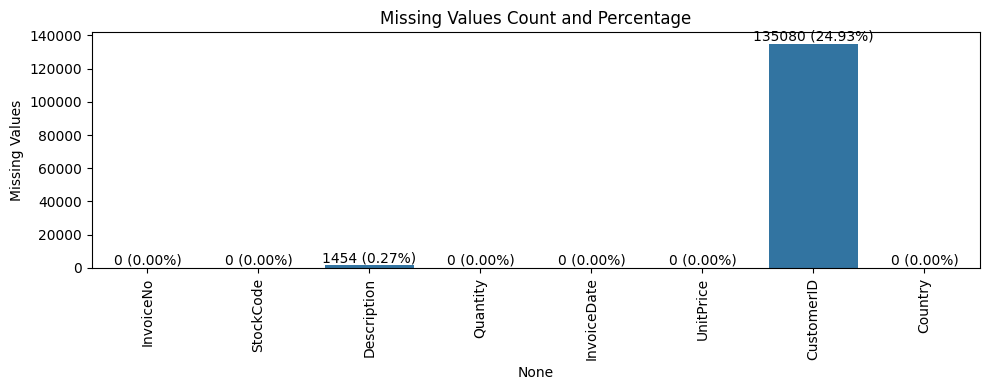

In [5]:
plt.figure(figsize=(10, 4))

# Calculate missing values and their percentage
missing_values = df.isna().sum()
missing_percentage = (missing_values / len(df)) * 100

# Combine both counts and percentages into a single dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Plot the missing values count and percentage
sns.barplot(x=missing_data.index, y=missing_data['Missing Values'], orient='v')
plt.title('Missing Values Count and Percentage')
plt.xticks(rotation=90)

# Annotate each bar with the count and percentage
for i in range(missing_data.shape[0]):
    plt.text(i, missing_data['Missing Values'][i], f'{missing_data["Missing Values"][i]} ({missing_data["Percentage"][i]:.2f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Investigate the null values further

In [6]:
# Extract records with null CustomerID
df_null_customer_id = df[df['CustomerID'].isna()]

# Print the head of the new dataframe
df_null_customer_id.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


## Drop Missing Values

In [7]:
df = df.dropna(subset=['CustomerID'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


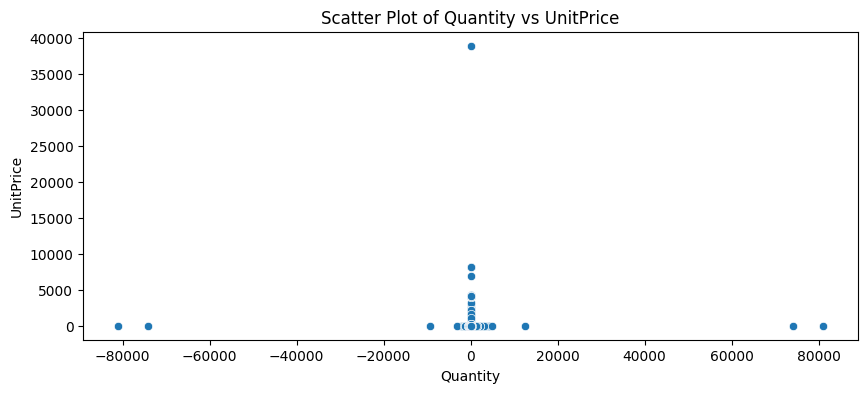

In [8]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df, x='Quantity', y='UnitPrice')
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.show()

## Add Attributes & Configure Data Types

In [9]:
df = df[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

In [10]:
# Convert nominal fields to categorical data types
df['InvoiceNo'] = df['InvoiceNo'].astype('category')
df['StockCode'] = df['StockCode'].astype('category')
df['Description'] = df['Description'].astype('str')
df['Quantity'] = df['Quantity'].astype('int')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['UnitPrice'] = df['UnitPrice'].astype('float')
df['CustomerID'] = df['CustomerID'].astype('int').astype('category')
df['Country'] = df['Country'].astype('category')

# Display the first few rows of the dataframe to verify changes
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [11]:
df.value_counts(['Quantity']).sort_index(ascending=False)

Quantity
 80995          1
 74215          1
 12540          1
 4800           1
 4300           1
 3906           1
 3186           1
 3114           2
 3000           1
 2880           2
 2700           1
 2592           1
 2400           4
 2160           1
 2100           1
 2040           1
 2000           4
 1992           1
 1944           2
 1930           2
 1900           1
 1878           1
 1824           1
 1788           1
 1728           3
 1600           2
 1540           1
 1515           1
 1500           3
 1488           1
 1440           9
 1428           1
 1412           1
 1404           1
 1400           1
 1394           1
 1356           1
 1350           1
 1300           2
 1296           8
 1284           1
 1200          18
 1152           7
 1120           1
 1056           2
 1020           1
 1010           1
 1008           4
 1000          10
 992            1
 972            2
 968            1
 960           13
 912            1
 906            1
 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  category      
 1   StockCode    406829 non-null  category      
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  category      
 7   Country      406829 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 19.2+ MB


In [13]:
# this shows the mapping between StockCode and Description, and the number of times each pair occurs

cts = df[['StockCode', 'Description']].value_counts().reset_index()
mixed_pairs = cts.value_counts('StockCode').sort_values(ascending=False)
cts = cts[cts['StockCode'].isin(mixed_pairs[mixed_pairs > 1].index)]
cts.sort_values('StockCode')

,StockCode,Description,count
2766,16156L,WRAP CAROUSEL,14
3407,16156L,"WRAP, CAROUSEL",4
2517,17107D,FLOWER FAIRY 5 DRAWER LINERS,21
3868,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS,1
2399,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS",25
2917,20622,VIP PASSPORT COVER,11
2502,20622,VIPPASSPORT COVER,22
3896,20725,LUNCH BAG RED SPOTTY,1
5,20725,LUNCH BAG RED RETROSPOT,1358
36,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,817


In [14]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [15]:
# generate derived attributes for the dataset
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df['InvoiceYear'] = df['InvoiceDate'].dt.to_period('Y')
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceDay'] = df['InvoiceDate'].dt.to_period('D')

df['Y'] = df['InvoiceDate'].dt.year
df['M'] = df['InvoiceDate'].dt.month
df['D'] = df['InvoiceDate'].dt.day
df['DOW'] = df['InvoiceDate'].dt.dayofweek # week starts with Monday=0 ... Sunday=6

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth,InvoiceDay,Y,M,D,DOW
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,2010-12,2010-12-01,2010,12,1,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,2010-12-01,2010,12,1,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,2010-12,2010-12-01,2010,12,1,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,2010-12-01,2010,12,1,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,2010-12-01,2010,12,1,2


## Visualize Distribution of Key Features (with an anomaly detection focus)

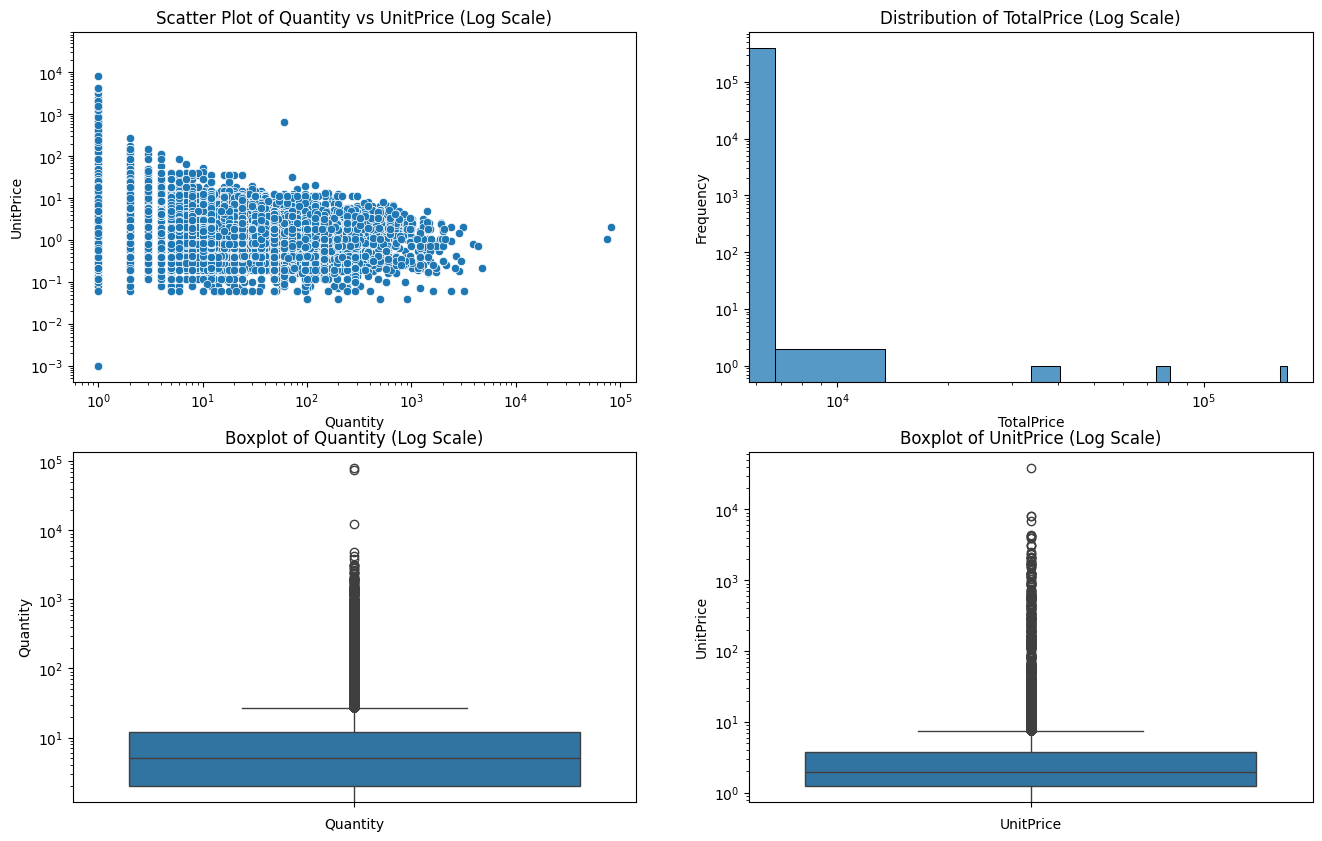

In [ ]:
plt.figure(figsize=(16, 10))

# Scatter plot of Quantity vs UnitPrice with logarithmic scale
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='Quantity', y='UnitPrice')
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Quantity vs UnitPrice (Log Scale)')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')

# Histogram of TotalPrice with logarithmic scale
plt.subplot(2, 2, 2)
sns.histplot(df['TotalPrice'], bins=50)
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of TotalPrice (Log Scale)')
plt.xlabel('TotalPrice')
plt.ylabel('Frequency')

# Boxplot for Quantity with logarithmic scale
plt.subplot(2, 2, 3)
sns.boxplot(df['Quantity'])
plt.yscale('log')
plt.title('Boxplot of Quantity (Log Scale)')
plt.xlabel('Quantity')

# Boxplot for UnitPrice with logarithmic scale
plt.subplot(2, 2, 4)
sns.boxplot(df['UnitPrice'])
plt.yscale('log')
plt.title('Boxplot of UnitPrice (Log Scale)')
plt.xlabel('UnitPrice')

plt.show()

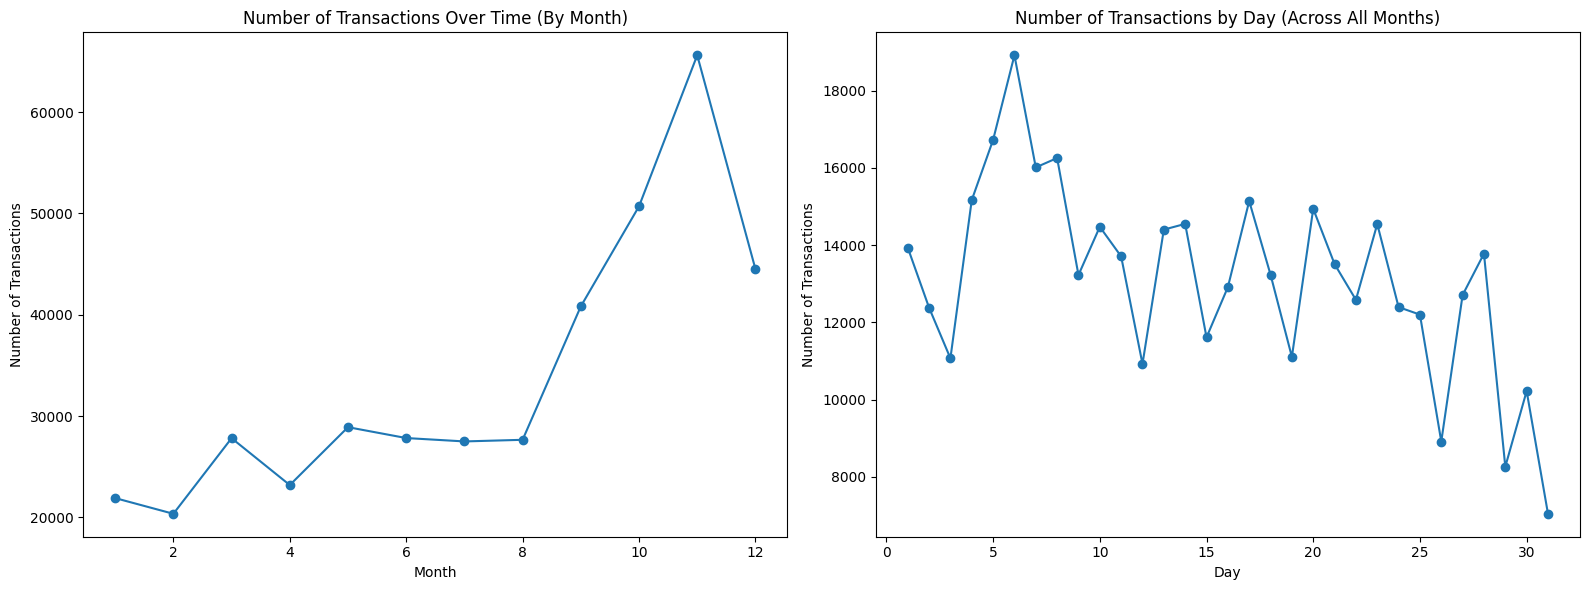

In [60]:
# Create a figure with two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Transactions per month
axes[0].plot(df['M'].value_counts().sort_index(), marker='o', linestyle='-')
axes[0].set_title('Number of Transactions Over Time (By Month)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Transactions')
axes[0].tick_params(axis='x')

# Second subplot: Transactions per day
axes[1].plot(df['D'].value_counts().sort_index(), marker='o', linestyle='-')
axes[1].set_title('Number of Transactions by Day (Across All Months)')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of Transactions')
axes[1].tick_params(axis='x')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with both subplots in one line
plt.show()


## WordCloud

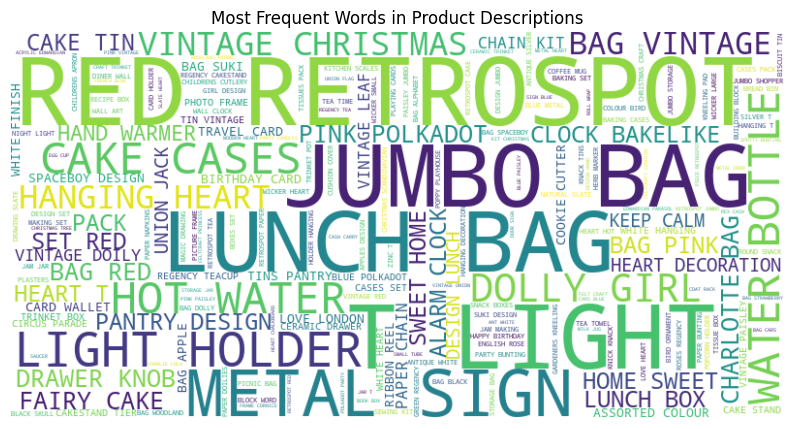

In [61]:
# Word Cloud to show the most frequent words in descriptions (as previously)

all_descriptions = ' '.join(df['Description'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Product Descriptions')
plt.show()

# Detecting Outliers

In [63]:
# Detecting Outliers in Key Numerical Variables

# Checking for outliers in Quantity, UnitPrice, and TotalPrice using interquartile range (IQR)
Q1 = df[['Quantity', 'UnitPrice', 'TotalPrice']].quantile(0.25)
Q3 = df[['Quantity', 'UnitPrice', 'TotalPrice']].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers as values that are 1.5*IQR beyond Q1 and Q3
outliers = ((df[['Quantity', 'UnitPrice', 'TotalPrice']] < (Q1 - 1.5 * IQR)) |
            (df[['Quantity', 'UnitPrice', 'TotalPrice']] > (Q3 + 1.5 * IQR))).sum()
print(f"Outliers in Quantity: {outliers['Quantity']}, Outliers in UnitPrice: {outliers['UnitPrice']}, Outliers in TotalPrice: {outliers['TotalPrice']}")


Outliers in Quantity: 26682, Outliers in UnitPrice: 36051, Outliers in TotalPrice: 33180


In [17]:
total_spent_per_cust = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
total_spent_per_cust[total_spent_per_cust['TotalPrice'] < 0].sort_values('TotalPrice', ascending=True)

C:\Users\nitin\AppData\Local\Temp\ipykernel_1828\1006674859.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_spent_per_cust = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()


,CustomerID,TotalPrice
3756,17448,-4.287630e+03
2236,15369,-1.592490e+03
1384,14213,-1.192200e+03
3870,17603,-1.165300e+03
125,12503,-1.126000e+03
2578,15823,-8.407600e+02
619,13154,-6.118600e+02
2560,15802,-4.514200e+02
2892,16252,-2.950900e+02
264,12666,-2.274400e+02


In [18]:
total_spent_per_cust['TotalPrice'].count()

np.int64(4372)

In [ ]:
df[df['TotalPrice'] < 0]['TotalPrice'].count()

np.int64(8905)

In [20]:
8905-4372

4533